### Idea

### Environment setting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

import os

Mounted at /content/gdrive


In [2]:
import pandas as pd
import re
import numpy as np

In [ ]:
%pip -U ckip-transformers

In [4]:
#from ckip_transformers.nlp import CkipWordSegmenter
from ckip_transformers.nlp import CkipPosTagger

### Read file

In [9]:
# read file
df = pd.read_csv('./data/ig5000.csv',encoding='utf-8')
df.head()

,text,label
0,V領設計能夠修飾臉型😍\r\n減齡泡泡袖洋裝😉\r\n👉https://lihi1.com/...,1
1,【20210303】\r\n能勇敢追夢的人\r\n身上都閃著和煦的光芒\r\n也是好生羨慕！...,0
2,玉 耳環\r\n#耳環 #玉 #earrings,1
3,【美國瘋潮WWE Taiwan】\r\n不管是WWE Elite還是AEW Unrivale...,1
4,🌈\r\n尋晚的post 一po已經被秒殺好多件的Vintage sports windbr...,1


In [6]:
# raw inspection
print(len(df))
df['label'].value_counts()

5000


0    2538
1    2462
Name: label, dtype: int64

### Text preprocessing



* extract hashtags
* clean
* tokenize
* postag



In [12]:
# WS
ws_driver = CkipWordSegmenter(device=0)

In [7]:
trash_re = "@\S+|https?:\S+|http?:\S|[^\u4E00-\u9FD5]"

def count_hashtag(texts):
    output = []
    for text in texts:
        text = str(text)
        hashtags = re.findall('(#[\w]+)',text)
        output.append(hashtags)
    return output

def clean(texts, clean_re):
    output = []
    for text in texts:
        text = re.sub(clean_re, '', str(text))
        output.append(text)
    return output

def tokenize(texts):
    output=[]
    ws = ws_driver(texts, use_delim = False)
    output = [" ".join(ls) for ls in ws]

    return ws, output

In [10]:
# extract hashtags
ig_hashtag = count_hashtag(df['text'].to_list())

In [16]:
ig_hashtag[:3]

[[], [], ['#耳環', '#玉', '#earrings']]

In [17]:
# clean & tokenize

ig_cleaned = clean(df['text'].to_list(), trash_re)
ig_ws, ig_segmented = tokenize(ig_cleaned)

Inference: 100%|██████████| 20/20 [02:26<00:00,  7.30s/it]


In [21]:
ig_ws[0], ig_segmented[0]

(['領', '設計', '能夠', '修飾', '臉型', '減齡', '泡泡袖', '洋裝', '領型領', '厚薄', '薄', '款'],
 '領 設計 能夠 修飾 臉型 減齡 泡泡袖 洋裝 領型領 厚薄 薄 款')

In [ ]:
# POS
pos_driver = CkipPosTagger(device=0)

In [8]:
ig_pos = pos_driver(ig_ws, use_delim = False)

Inference: 100%|██████████| 20/20 [02:36<00:00,  7.82s/it]


['./ig_pos.pkl']

In [ ]:
#@title joblib 
#import joblib 
#joblib.dump(ig_ws, './ig_ws.pkl')
#joblib.dump(ig_segmented, './ig_segmented.pkl')
#joblib.dump(ig_pos, './ig_pos.pkl')

### Generate 4 features 

* text length
* lexical diversity
* pos diversity
* hashtag_n

In [5]:
# 要傳ig_segmented
def textLength(texts):
  output = []
  for text in texts:
    text = text.replace(" ", "")
    length = len(text)
    output.append(length)
  
  return output


# 要傳ig_ws
def lexicalDiversity(texts):
  output = []
  for text in texts:
    if len(text) == 0:
      diversity = 0
    else: 
      diversity = float(len(set(text))) / len(text)
    
    output.append(diversity)
  
  return output

In [48]:
text = ['玉', '耳環', '耳環', '玉']
print(len(set(text)), len(text))
float(len(set(text))) / len(text)

1 4


0.25

In [3]:
import joblib 
ig_ws = joblib.load('./ig_ws.pkl')
ig_segmented = joblib.load('./ig_segmented.pkl')
ig_pos = joblib.load('./ig_pos.pkl')

In [11]:
ig_length = textLength(ig_segmented)
ig_diversity = lexicalDiversity(ig_ws)
ig_pos_diversity = lexicalDiversity(ig_pos)
ig_hashtag_n = [len(x) for x in ig_hashtag]

In [12]:
# 原始資料+兩個feature建成corpus

corpus = pd.DataFrame({
    'Text':ig_segmented,
    'Text Length':ig_length,
    'Lexical Diversity':ig_diversity,
    'POS':ig_pos,
    'POS Diversity':ig_pos_diversity,
    'Hashtag':ig_hashtag,
    'Hashtag_n':ig_hashtag_n,
    'Label':df['label']
  })

corpus.head()

,Text,Text Length,Lexical Diversity,POS,POS Diversity,Hashtag,Hashtag_n,Label
0,領 設計 能夠 修飾 臉型 減齡 泡泡袖 洋裝 領型領 厚薄 薄 款,23,1.000000,"[VC, Na, D, VC, Na, VJ, Na, Na, Na, Na, VH, Na]",0.416667,[],0,1
1,能 勇敢 追 夢 的 人 身 上 都 閃 著 和煦 的 光芒 也 是 好生 羨慕 敬 那 天...,44,0.823529,"[D, VH, VC, Na, DE, Na, Na, Ncd, D, VC, Di, VH...",0.382353,[],0,0
2,玉 耳環 耳環 玉,6,0.500000,"[Na, Na, Na, Na]",0.250000,"[#耳環, #玉, #earrings]",3,1
3,美國 瘋潮 不管 是 還是 系列 的 人偶 公仔 在 這 應有盡有 正版 周邊 商品 人氣 ...,124,0.692308,"[Nc, Na, Cbb, SHI, D, Na, DE, Na, Na, P, Nep, ...",0.276923,"[#wwetees, #公仔人偶, #cosplay, #美國瘋潮, #WWE, #WWEs...",21,1
4,尋晚 的 一 已經 被 秒殺 好多 件 的 每 一 件 成色 和 都 好 靚 而且 都 是 ...,117,0.767442,"[VC, DE, Neu, D, P, VC, Neqa, Nf, DE, Nes, Neu...",0.302326,"[#男女可穿, #unisex, #vintagewindbreaker, #NIKE, #...",8,1


In [ ]:
#joblib.dump(corpus, './corpus.pkl')

### Feature distirbution

In [ ]:
import joblib 
corpus = joblib.load('./data/corpus.pkl')

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


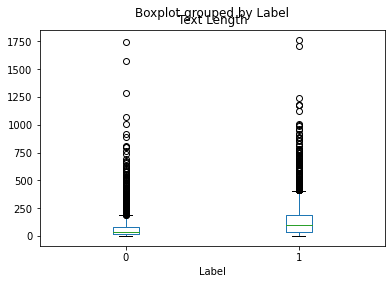

In [64]:
corpus.boxplot(by ='Label', column =['Text Length'], grid = False)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


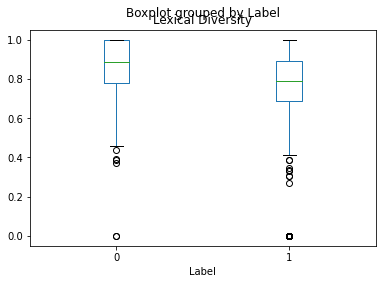

In [65]:
corpus.boxplot(by ='Label', column =['Lexical Diversity'], grid = False)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


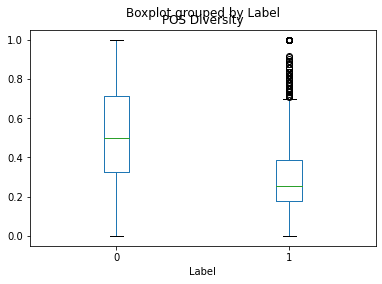

In [66]:
corpus.boxplot(by ='Label', column =['POS Diversity'], grid = False)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


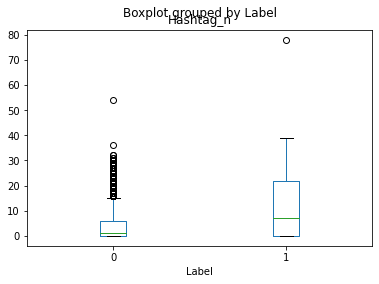

In [29]:
corpus.boxplot(by ='Label', column =['Hashtag_n'], grid = False)

### Normalize features & train-test dataset

In [18]:
# normalize
from sklearn.preprocessing import StandardScaler

def normalize(corpus):

  feature_cols = corpus.drop(["Text","Label",'POS','Hashtag'], axis=1)
  scale = StandardScaler() 
  #fea2_scaled = pd.DataFrame(scale.fit_transform(fea2), columns=fea2.keys())
  features_scaled = scale.fit_transform(feature_cols)

  return features_scaled

In [22]:
features_scaled = normalize(corpus)
features_scaled.shape

(5000, 4)

In [24]:
feature_cols = ['Text Length', 'Lexical Diversity','POS Diversity','Hashtag_n']

corpus_norm = pd.DataFrame(features_scaled, columns=feature_cols)
corpus_norm['Text'] = corpus['Text'].to_list()
corpus_norm['Label'] = corpus['Label'].to_list()

corpus_norm

,Text Length,Lexical Diversity,POS Diversity,Hashtag_n,Text,Label
0,-0.584318,0.982801,-0.020384,-0.798228,領 設計 能夠 修飾 臉型 減齡 泡泡袖 洋裝 領型領 厚薄 薄 款,1
1,-0.436743,0.063199,-0.152292,-0.798228,能 勇敢 追 夢 的 人 身 上 都 閃 著 和煦 的 光芒 也 是 好生 羨慕 敬 那 天...,0
2,-0.703784,-1.622740,-0.661079,-0.499699,玉 耳環 耳環 玉,1
3,0.125447,-0.620608,-0.557582,1.291479,美國 瘋潮 不管 是 還是 系列 的 人偶 公仔 在 這 應有盡有 正版 周邊 商品 人氣 ...,1
4,0.076255,-0.229078,-0.459930,-0.002149,尋晚 的 一 已經 被 秒殺 好多 件 的 每 一 件 成色 和 都 好 靚 而且 都 是 ...,1
...,...,...,...,...,...,...
4995,-0.584318,0.035332,0.474698,-0.798228,長桿 綠瑪瑙 煙嘴 煙斗 復古 長桿 煙斗 塞入 菸草 即可 使用,1
4996,0.771966,-0.353373,-0.899286,1.590008,抗 敏 之 選 藍甘菊 舒緩 潔面乳 好多 美容院 都 用 佢 功效 保濕 補充 肌膚 水份...,1
4997,-0.542154,0.676267,0.865282,-0.798228,今天 特地 比較 慢 出門 但 還是 太早 到 學校 了 可能 下雨 關係 車 好多 今天,1
4998,-0.268086,0.297133,-0.104686,1.590008,大量 韓國 新貨 上架 歡迎 到 門市 選購 查詢 下單 到 門市 太子 聯合 廣場 網購 ...,1


### Classification

In [42]:
from sklearn import metrics
from sklearn.metrics import recall_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#### all features

In [31]:
X = corpus_norm[feature_cols]
y = corpus_norm.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [33]:
# model
model = LogisticRegression()

In [ ]:
# fit 
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

In [50]:
print('Accurracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, y_pred)),'\n')

print(classification_report(y_test, y_pred))

Accurracy: 0.7152
Recall: 0.7852 

              precision    recall  f1-score   support

           0       0.77      0.65      0.71       654
           1       0.67      0.79      0.72       596

    accuracy                           0.72      1250
   macro avg       0.72      0.72      0.71      1250
weighted avg       0.72      0.72      0.71      1250



In [35]:
confusion_matrix(y_test, y_pred)

array([[426, 228],
       [128, 468]])

Dummy baseline

In [51]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
    
print('Dummy Accurracy: {:.4f}'.format(accuracy_score(y_test, dummy_pred)),'\n')
print(classification_report(y_test, dummy_pred))
print(confusion_matrix(y_test,dummy_pred))

Dummy Accurracy: 0.5232 

              precision    recall  f1-score   support

           0       0.52      1.00      0.69       654
           1       0.00      0.00      0.00       596

    accuracy                           0.52      1250
   macro avg       0.26      0.50      0.34      1250
weighted avg       0.27      0.52      0.36      1250

[[654   0]
 [596   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3 features

In [52]:
X = corpus_norm[['Text Length', 'Lexical Diversity','POS Diversity']] # 拿掉 hashtag_n
y = corpus_norm.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

# model
model = LogisticRegression()

# fit 
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

In [55]:
print('Accurracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, y_pred)),'\n')

print(classification_report(y_test, y_pred))

Accurracy: 0.7200
Recall: 0.8289 

              precision    recall  f1-score   support

           0       0.80      0.62      0.70       654
           1       0.67      0.83      0.74       596

    accuracy                           0.72      1250
   macro avg       0.73      0.72      0.72      1250
weighted avg       0.74      0.72      0.72      1250



In [56]:
X = corpus_norm[['Text Length', 'Lexical Diversity','Hashtag_n']] # 拿掉 POS Diversity
y = corpus_norm.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

# model
model = LogisticRegression()

# fit 
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

In [58]:
print('Accurracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, y_pred)),'\n')

print(classification_report(y_test, y_pred))

Accurracy: 0.6808
Recall: 0.6242 

              precision    recall  f1-score   support

           0       0.68      0.73      0.71       654
           1       0.68      0.62      0.65       596

    accuracy                           0.68      1250
   macro avg       0.68      0.68      0.68      1250
weighted avg       0.68      0.68      0.68      1250



In [59]:
X = corpus_norm[['Text Length', 'POS Diversity','Hashtag_n']] # 拿掉 Lexical Diversity
y = corpus_norm.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

# model
model = LogisticRegression()

# fit 
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

In [61]:
print('Accurracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, y_pred)),'\n')

print(classification_report(y_test, y_pred))

Accurracy: 0.7152
Recall: 0.7852 

              precision    recall  f1-score   support

           0       0.77      0.65      0.71       654
           1       0.67      0.79      0.72       596

    accuracy                           0.72      1250
   macro avg       0.72      0.72      0.71      1250
weighted avg       0.72      0.72      0.71      1250



In [62]:
X = corpus_norm[['Lexical Diversity', 'POS Diversity','Hashtag_n']] # 拿掉 Text Length
y = corpus_norm.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

# model
model = LogisticRegression()

# fit 
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

In [63]:
print('Accurracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, y_pred)),'\n')

print(classification_report(y_test, y_pred))

Accurracy: 0.7160
Recall: 0.7735 

              precision    recall  f1-score   support

           0       0.76      0.66      0.71       654
           1       0.68      0.77      0.72       596

    accuracy                           0.72      1250
   macro avg       0.72      0.72      0.72      1250
weighted avg       0.72      0.72      0.72      1250

